<a href="https://colab.research.google.com/github/SophGrace24/AIModels/blob/main/EMBR__Completed_Unit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [80]:
import numpy as np
import matplotlib.pyplot as plt

## Unit class defintion

In [81]:
class Unit:
    def __init__(self,
                 starting_pos_attraction=None,
                 starting_neg_attraction=None,
                 starting_cat1_attraction=None, # New category attraction
                 starting_cat2_attraction=None, # New category attraction
                 decay_factor=0.9,
                 influence_factor=0.1,
                 nudge_amount=0.00005):

        # --- Unit's Core Parameters ---
        self.positive_attraction = starting_pos_attraction if starting_pos_attraction is not None else np.random.rand()
        self.negative_attraction = starting_neg_attraction if starting_neg_attraction is not None else np.random.rand()
        self.category1_attraction = starting_cat1_attraction if starting_cat1_attraction is not None else np.random.rand()
        self.category2_attraction = starting_cat2_attraction if starting_cat2_attraction is not None else np.random.rand()

        # Internal state(s) - these states persist across waves.
        self.internal_states = [0.0, 0.0] # [State for Pos/Neg, State for Cat1/Cat2]

        # Fixed processing rules for this unit's "physics"
        self.decay_factor = decay_factor
        self.influence_factor = influence_factor # Influence factor is now fixed at init, no longer adapts from prediction
        self.nudge_amount = nudge_amount # Base amount for random nudges

        # Memory for prediction (still exists, but not used for accuracy/self-correction now)
        self.last_bit_sign = 0 # 0 for neutral, 1 for positive, -1 for negative
        self.category_state_memory = [0.0] * 5 # Stores the last 5 category polished states

        print(f"\n--- New Unit Initialized ---")
        print(f"  Pos Attraction: {self.positive_attraction:.4f}, Neg Attraction: {self.negative_attraction:.4f}")
        print(f"  Cat1 Attraction: {self.category1_attraction:.4f}, Cat2 Attraction: {self.category2_attraction:.4f}")
        print(f"  Decay Factor: {self.decay_factor}, Influence Factor: {self.influence_factor}")


    def process_wave(self, environmental_wave):
        """
        Processes a single environmental wave, updating unit's internal states and attractions.
        States are cumulative across waves.
        """
        # --- NO RESET OF PREDICTION COUNTS HERE ANYMORE ---

        for bit in environmental_wave:
            # --- Prediction Logic (as before, its self-correction is removed) ---
            prediction = 0 # Default prediction
            avg_memory_state = 0.0

            if len(self.category_state_memory) > 0:
                avg_memory_state = np.mean(self.category_state_memory)

                if avg_memory_state < 0: # If recent categorical history is generally negative (leaning Cat2)
                    prediction = -1 # Predict negative
                else: # if avg_memory_state is 0 or positive, prediction remains 1 (positive)
                    prediction = 1


            # --- Logic for Positive/Negative Attraction and State Update ---
            # Added random nudge to self.nudge_amount
            random_nudge_pos_neg = np.random.uniform(-self.nudge_amount, self.nudge_amount)
            if bit > 0 and self.positive_attraction >= self.negative_attraction:
                self.internal_states[0] = (self.internal_states[0] * self.decay_factor) + (bit * self.influence_factor)
                self.positive_attraction = np.clip(self.positive_attraction + (self.nudge_amount + random_nudge_pos_neg), 0.0, 1.0)
                self.negative_attraction = np.clip(self.negative_attraction - (self.nudge_amount + random_nudge_pos_neg), 0.0, 1.0)

            elif bit < 0 and self.negative_attraction > self.positive_attraction:
                self.internal_states[0] = (self.internal_states[0] * self.decay_factor) + (bit * self.influence_factor)
                self.negative_attraction = np.clip(self.negative_attraction + (self.nudge_amount + random_nudge_pos_neg), 0.0, 1.0)
                self.positive_attraction = np.clip(self.positive_attraction - (self.nudge_amount + random_nudge_pos_neg), 0.0, 1.0)

            # --- Logic for Category 1/Category 2 Attraction and State Update ---
            # Added random nudge to self.nudge_amount
            random_nudge_cat = np.random.uniform(-self.nudge_amount, self.nudge_amount)
            if self.category1_attraction >= self.category2_attraction:
                self.internal_states[1] = (self.internal_states[1] * self.decay_factor) + (1.0 * self.influence_factor)
                self.category1_attraction = np.clip(self.category1_attraction + (self.nudge_amount + random_nudge_cat), 0.0, 1.0)
                self.category2_attraction = np.clip(self.category2_attraction - (self.nudge_amount + random_nudge_cat), 0.0, 1.0)

            else: # self.category2_attraction > self.category1_attraction
                self.internal_states[1] = (self.internal_states[1] * self.decay_factor) + (-1.0 * self.influence_factor)
                self.category2_attraction = np.clip(self.category2_attraction + (self.nudge_amount + random_nudge_cat), 0.0, 1.0)
                self.category1_attraction = np.clip(self.category1_attraction - (self.nudge_amount + random_nudge_cat), 0.0, 1.0)


            # --- NO PREDICTION ACCURACY COUNTING OR SELF-CORRECTION HERE ---
            # These parts were removed. Influence factor is fixed.


            # --- Store the sign of the current bit for the next prediction (last step in the loop) ---
            if bit > 0:
                self.last_bit_sign = 1
            elif bit < 0:
                self.last_bit_sign = -1
            else: # bit is 0
                self.last_bit_sign = 0

        return self.internal_states

## The run_adaptive_unit_simulation_experiment function

In [82]:
def run_adaptive_unit_simulation_experiment(num_observation_cycles=100):
    """
    Runs an experiment with a single Unit instance.
    """
    my_unit = Unit()

    history_pos_neg_state = []
    history_cat1_cat2_state = []
    history_cat1_attraction = []
    history_cat2_attraction = []
    cat_state_stability_history = [] # NEW: To store stability metric


    print("\nStarting multi-cycle observation for the unit...")

    for cycle in range(num_observation_cycles):
        # Generate a NEW environmental wave for each cycle
        environmental_wave = np.random.uniform(-1.0, 1.0, size=1000)

        # Process the wave using the unit's method
        final_states_this_cycle = my_unit.process_wave(environmental_wave)

        # Record the final polished states for this cycle
        history_pos_neg_state.append(final_states_this_cycle[0])
        history_cat1_cat2_state.append(final_states_this_cycle[1])
        history_cat1_attraction.append(my_unit.category1_attraction)
        history_cat2_attraction.append(my_unit.category2_attraction)

        # Calculate stability metric for Cat1/Cat2 State
        # Requires at least 5 cycles to calculate std dev
        if len(history_cat1_cat2_state) >= 5:
            # Get the last 5 polished Cat1/Cat2 states
            last_5_cat_states = history_cat1_cat2_state[-5:]
            # Calculate standard deviation of these last 5 states
            stability_metric = np.std(last_5_cat_states)
            cat_state_stability_history.append(stability_metric)
        else:
            cat_state_stability_history.append(np.nan) # Not a number until enough data

        # Optional: print progress every few cycles
        if (cycle + 1) % 10 == 0:
            print(f"  Cycle {cycle + 1}/{num_observation_cycles}")
            print(f"    Final Pos/Neg State: {final_states_this_cycle[0]:.4f}")
            print(f"    Current Attractions: Pos={my_unit.positive_attraction:.4f}, Neg={my_unit.negative_attraction:.4f}")
            print(f"    Final Cat1/Cat2 State: {final_states_this_cycle[1]:.4f}")
            print(f"    Current Cat Attractions: Cat1={my_unit.category1_attraction:.4f}, Cat2={my_unit.category2_attraction:.4f}")
            if not np.isnan(cat_state_stability_history[-1]): # Only print if not NaN
                print(f"    Cat1/Cat2 State Stability: {cat_state_stability_history[-1]:.4f}")


    print("\nObservation cycles complete.")
    print(f"Final Attractions after all cycles: Pos={my_unit.positive_attraction:.4f}, Neg={my_unit.negative_attraction:.4f}")
    print(f"Final Cat Attractions after all cycles: Cat1={my_unit.category1_attraction:.4f}, Cat2={my_unit.category2_attraction:.4f}")

    # Return all relevant histories
    return history_pos_neg_state, history_cat1_cat2_state, history_cat1_attraction, history_cat2_attraction, cat_state_stability_history

## Running Simulation and Plotting


--- New Unit Initialized ---
  Pos Attraction: 0.3234, Neg Attraction: 0.2035
  Cat1 Attraction: 0.9563, Cat2 Attraction: 0.4296
  Decay Factor: 0.9, Influence Factor: 0.1

Starting multi-cycle observation for the unit...
  Cycle 10/100
    Final Pos/Neg State: 0.4645
    Current Attractions: Pos=0.5676, Neg=0.0000
    Final Cat1/Cat2 State: 1.0000
    Current Cat Attractions: Cat1=1.0000, Cat2=0.0000
    Cat1/Cat2 State Stability: 0.0000
  Cycle 20/100
    Final Pos/Neg State: 0.3353
    Current Attractions: Pos=0.8177, Neg=0.0000
    Final Cat1/Cat2 State: 1.0000
    Current Cat Attractions: Cat1=1.0000, Cat2=0.0000
    Cat1/Cat2 State Stability: 0.0000
  Cycle 30/100
    Final Pos/Neg State: 0.4701
    Current Attractions: Pos=1.0000, Neg=0.0000
    Final Cat1/Cat2 State: 1.0000
    Current Cat Attractions: Cat1=1.0000, Cat2=0.0000
    Cat1/Cat2 State Stability: 0.0000
  Cycle 40/100
    Final Pos/Neg State: 0.4096
    Current Attractions: Pos=1.0000, Neg=0.0000
    Final Cat1/Cat2

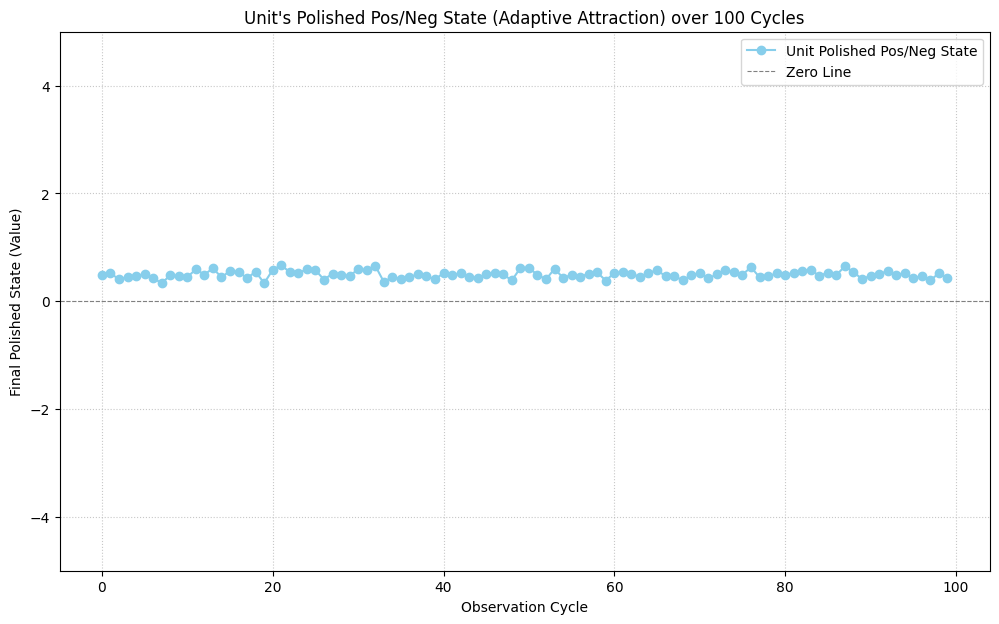

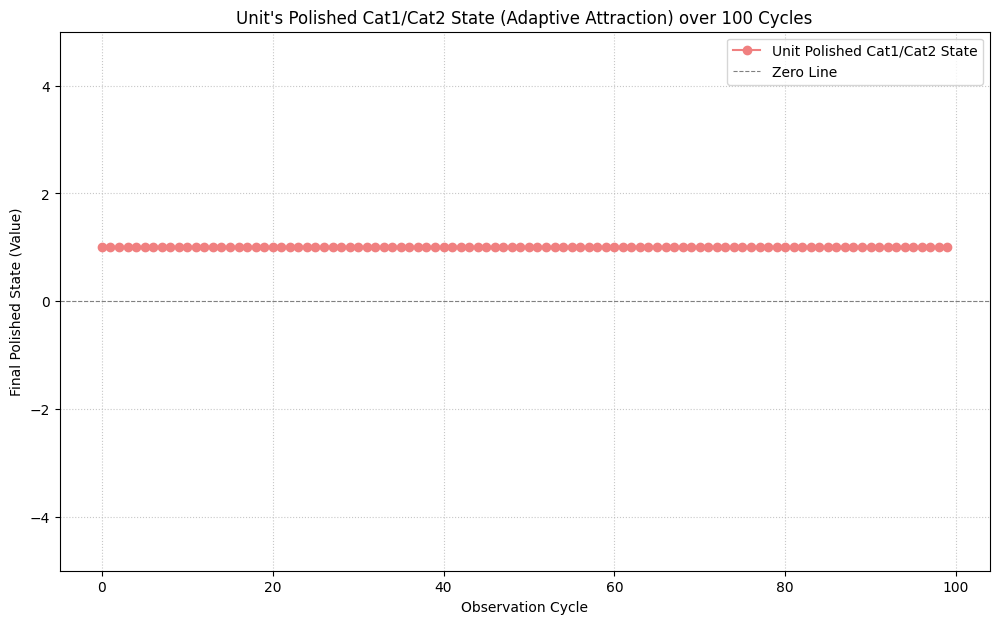

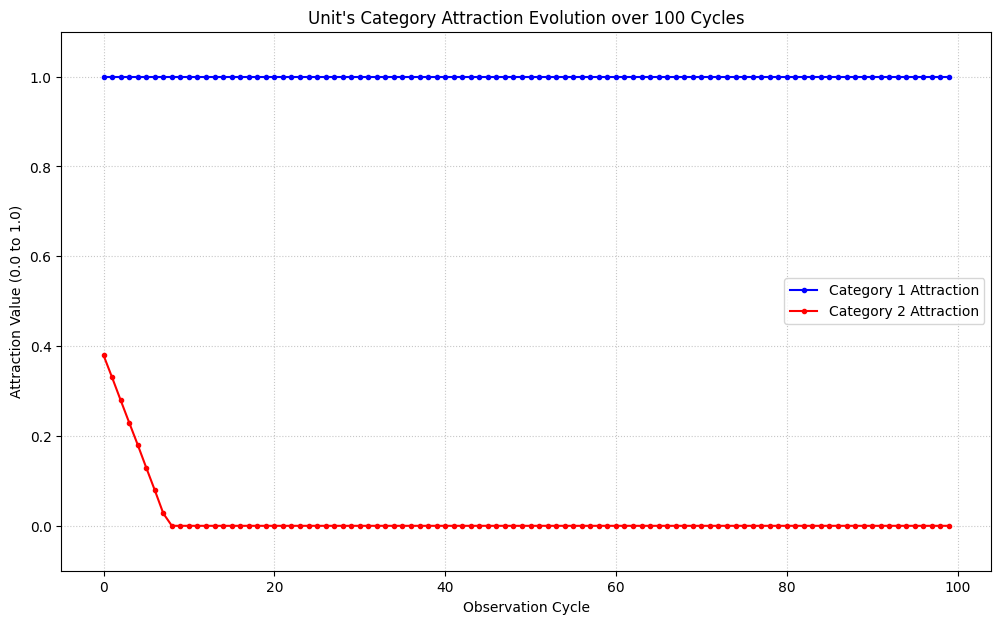

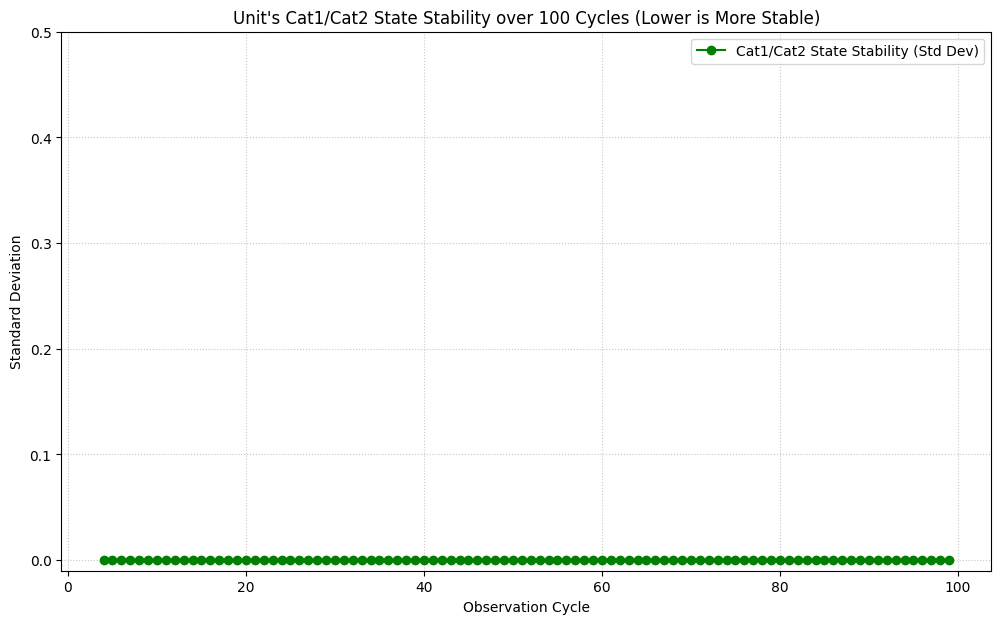

In [83]:
if __name__ == "__main__":
    # Run the simulation and get all histories
    pos_neg_history, cat_state_history, cat1_attraction_history, cat2_attraction_history, cat_state_stability_history = run_adaptive_unit_simulation_experiment(num_observation_cycles=100)

    # --- Plotting the Primary State History (Pos/Neg) ---
    plt.close('all') # Close any previous figures
    plt.figure(figsize=(12, 7))
    plt.plot(pos_neg_history, marker='o', linestyle='-', color='skyblue', label='Unit Polished Pos/Neg State')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, label='Zero Line')
    plt.title(f"Unit's Polished Pos/Neg State (Adaptive Attraction) over {len(pos_neg_history)} Cycles")
    plt.xlabel("Observation Cycle")
    plt.ylabel("Final Polished State (Value)")
    plt.ylim(-5.0, 5.0) # Adjusted range
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.show()

    # --- Plotting the Secondary State History (Cat1/Cat2 State) ---
    plt.close('all')
    plt.figure(figsize=(12, 7))
    plt.plot(cat_state_history, marker='o', linestyle='-', color='lightcoral', label='Unit Polished Cat1/Cat2 State')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, label='Zero Line')
    plt.title(f"Unit's Polished Cat1/Cat2 State (Adaptive Attraction) over {len(cat_state_history)} Cycles")
    plt.xlabel("Observation Cycle")
    plt.ylabel("Final Polished State (Value)")
    plt.ylim(-5.0, 5.0) # Adjusted range
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.show()

    # --- Plotting the Category Attractions Evolution ---
    plt.close('all')
    plt.figure(figsize=(12, 7))
    plt.plot(cat1_attraction_history, marker='.', linestyle='-', color='blue', label='Category 1 Attraction')
    plt.plot(cat2_attraction_history, marker='.', linestyle='-', color='red', label='Category 2 Attraction')
    plt.title(f"Unit's Category Attraction Evolution over {len(cat1_attraction_history)} Cycles")
    plt.xlabel("Observation Cycle")
    plt.ylabel("Attraction Value (0.0 to 1.0)")
    plt.ylim(-0.1, 1.1)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.show()

    # --- NEW PLOT: Cat1/Cat2 State Stability ---
    plt.close('all')
    plt.figure(figsize=(12, 7))
    plt.plot(cat_state_stability_history, marker='o', linestyle='-', color='green', label='Cat1/Cat2 State Stability (Std Dev)')
    plt.title(f"Unit's Cat1/Cat2 State Stability over {len(cat_state_stability_history)} Cycles (Lower is More Stable)")
    plt.xlabel("Observation Cycle")
    plt.ylabel("Standard Deviation")
    plt.ylim(-0.01, 0.5) # Example range, adjust as needed
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.show()